In [1]:
from fraudfunc import fdr_score, fdr_summary, trn_resample
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
import warnings
warnings.filterwarnings('ignore')

In [2]:
mod = pd.read_csv('modeling_data.csv')
oot = pd.read_csv('oot_data.csv')

In [3]:
X_mod=mod.iloc[:,:-1]
y_mod=mod.iloc[:,-1]
X_oot=oot.iloc[:,:-1]
y_oot=oot.iloc[:,-1]

In [33]:
bt=GradientBoostingClassifier(n_estimators=1000,
                              max_features=5,
                              min_samples_leaf=30,
                              min_samples_split=100)

X_train,X_test,y_train,y_test=train_test_split(X_mod,y_mod,test_size=0.3,stratify=y_mod)
X_train_ds,y_train_ds=trn_resample(X_train,y_train)
bt.fit(X_train_ds, y_train_ds)
y_train_pred_prob = bt.predict_proba(X_train)[:,1]
y_test_pred_prob = bt.predict_proba(X_test)[:,1]

trn_fdr=fdr_score(y_train_pred_prob,y_train)
tst_fdr=fdr_score(y_test_pred_prob,y_test)

X_mod_ds,y_mod_ds=trn_resample(X_mod,y_mod)
bt.fit(X_mod_ds, y_mod_ds)
y_oot_pred_prob = bt.predict_proba(X_oot)[:,1]
oot_fdr=fdr_score(y_oot_pred_prob,y_oot)

print(trn_fdr,tst_fdr,oot_fdr)

1.0 0.95 0.5810055865921788


In [89]:
y_mod_pred_prob=bt.predict_proba(X_mod)[:,1]
print(fdr_score(y_mod_pred_prob,y_mod))

1.0


In [91]:
# trainDF=pd.DataFrame(y_train)
# trainDF['pred']=y_train_pred_prob
# testDF=pd.DataFrame(y_test)
# testDF['pred']=y_test_pred_prob
# modDF=pd.concat([trainDF,testDF])
# modDF=modDF.sort_index()
modDF=pd.DataFrame(y_mod)
modDF['pred']=y_mod_pred_prob
ootDF=pd.DataFrame(y_oot)
ootDF['pred']=y_oot_pred_prob
allDF=pd.concat([modDF,ootDF])

In [83]:
ootDF.to_csv('oot_pred.csv',index=False)

In [93]:
allDF.to_csv('all_pred1.csv',index=False)

### Train

In [52]:
import math

In [36]:
train_df = pd.DataFrame([y_train_pred_prob,y_train]).T
train_df.columns = ['pred_prob','label']
train_df = train_df.sort_values('pred_prob',ascending=False).reset_index()

In [37]:
trn_n_records = len(train_df)
trn_n_bads = sum(train_df['label'])
trn_n_goods = trn_n_records - trn_n_bads
trn_fraud_rt = trn_n_bads / trn_n_records

print('# Records:', trn_n_records)
print('# Bads:', trn_n_bads)
print('# Goods:', trn_n_goods)
print('Fraud Rate:', trn_fraud_rt)

# Records: 56442
# Bads: 608.0
# Goods: 55834.0
Fraud Rate: 0.010772120052443216


In [55]:
bin_size = int(math.ceil(len(train_df)/100))
print('Bin size',bin_size)
train_df['bins'] = pd.Series(train_df.index).floordiv(bin_size)
train_df['bins'] = train_df['bins'] + 1
train_df.head()

Bin size 565


,index,pred_prob,label,bins
0,35721,1.0,1.0,1
1,29709,1.0,1.0,1
2,38424,1.0,1.0,1
3,4390,1.0,1.0,1
4,45143,1.0,1.0,1


In [58]:
# Each bin
trnSummary = train_df.groupby('bins').size().reset_index(name='# Records')
trnSummary = trnSummary.merge(train_df.groupby('bins').sum()['label'].reset_index(name='# Bads'))
trnSummary['# Goods'] = trnSummary['# Records'] - trnSummary['# Bads']
trnSummary['% Bads'] = trnSummary['# Bads'] / trnSummary['# Records']
trnSummary['% Goods'] = trnSummary['# Goods'] / trnSummary['# Records']

# Cumulative
trnSummary['Total # Records'] = trnSummary['# Records'].cumsum()
trnSummary['Cumulative Goods'] = trnSummary['# Goods'].cumsum()
trnSummary['Cumulative Bads'] = trnSummary['# Bads'].cumsum()
trnSummary['% Goods Cum.'] = trnSummary['Cumulative Goods'] / trn_n_goods
trnSummary['% Bads (FDR)'] = trnSummary['Cumulative Bads'] / trn_n_bads
trnSummary['KS'] = trnSummary['% Bads (FDR)'] - trnSummary['% Goods Cum.']
trnSummary['FPR'] = trnSummary['Cumulative Goods'] / trnSummary['Cumulative Bads']

In [59]:
trnSummary.tail(20)

,bins,# Records,# Bads,# Goods,% Bads,% Goods,Total # Records,Cumulative Goods,Cumulative Bads,% Goods Cum.,% Bads (FDR),KS,FPR
80,81,565,0.0,565.0,0.0,1.0,45765,45157.0,608.0,0.808772,1.0,0.191228,74.271382
81,82,565,0.0,565.0,0.0,1.0,46330,45722.0,608.0,0.818892,1.0,0.181108,75.200658
82,83,565,0.0,565.0,0.0,1.0,46895,46287.0,608.0,0.829011,1.0,0.170989,76.129934
83,84,565,0.0,565.0,0.0,1.0,47460,46852.0,608.0,0.839130,1.0,0.160870,77.059211
84,85,565,0.0,565.0,0.0,1.0,48025,47417.0,608.0,0.849250,1.0,0.150750,77.988487
85,86,565,0.0,565.0,0.0,1.0,48590,47982.0,608.0,0.859369,1.0,0.140631,78.917763
86,87,565,0.0,565.0,0.0,1.0,49155,48547.0,608.0,0.869488,1.0,0.130512,79.847039
87,88,565,0.0,565.0,0.0,1.0,49720,49112.0,608.0,0.879607,1.0,0.120393,80.776316
88,89,565,0.0,565.0,0.0,1.0,50285,49677.0,608.0,0.889727,1.0,0.110273,81.705592
89,90,565,0.0,565.0,0.0,1.0,50850,50242.0,608.0,0.899846,1.0,0.100154,82.634868


### Test

In [41]:
test_df = pd.DataFrame([y_test_pred_prob,y_test]).T
test_df.columns = ['pred_prob','label']
test_df = test_df.sort_values('pred_prob',ascending=False).reset_index()

In [42]:
tst_n_records = len(test_df)
tst_n_bads = sum(test_df['label'])
tst_n_goods = tst_n_records - tst_n_bads
tst_fraud_rt = tst_n_bads / tst_n_records

print('# Records:', tst_n_records)
print('# Bads:', tst_n_bads)
print('# Goods:', tst_n_goods)
print('Fraud Rate:', tst_fraud_rt)

# Records: 24190
# Bads: 260.0
# Goods: 23930.0
Fraud Rate: 0.010748243075651096


In [60]:
tst_bin_size = int(math.ceil(len(test_df)/100))
print('Bin size',tst_bin_size)
test_df['bins'] = pd.Series(test_df.index).floordiv(tst_bin_size)
test_df['bins'] = test_df['bins'] + 1
test_df.head()

Bin size 242


,index,pred_prob,label,bins
0,21998,0.999998,1.0,1
1,17018,0.999998,1.0,1
2,23484,0.999998,1.0,1
3,16131,0.999997,1.0,1
4,4277,0.999997,1.0,1


In [61]:
# Each bin
tstSummary = test_df.groupby('bins').size().reset_index(name='# Records')
tstSummary = tstSummary.merge(test_df.groupby('bins').sum()['label'].reset_index(name='# Bads'))
tstSummary['# Goods'] = tstSummary['# Records'] - tstSummary['# Bads']
tstSummary['% Bads'] = tstSummary['# Bads'] / tstSummary['# Records']
tstSummary['% Goods'] = tstSummary['# Goods'] / tstSummary['# Records']

# Cumulative
tstSummary['Total # Records'] = tstSummary['# Records'].cumsum()
tstSummary['Cumulative Goods'] = tstSummary['# Goods'].cumsum()
tstSummary['Cumulative Bads'] = tstSummary['# Bads'].cumsum()
tstSummary['% Goods Cum.'] = tstSummary['Cumulative Goods'] / tst_n_goods
tstSummary['% Bads (FDR)'] = tstSummary['Cumulative Bads'] / tst_n_bads
tstSummary['KS'] = tstSummary['% Bads (FDR)'] - tstSummary['% Goods Cum.']
tstSummary['FPR'] = tstSummary['Cumulative Goods'] / tstSummary['Cumulative Bads']

In [63]:
tstSummary.head(20)

,bins,# Records,# Bads,# Goods,% Bads,% Goods,Total # Records,Cumulative Goods,Cumulative Bads,% Goods Cum.,% Bads (FDR),KS,FPR
0,1,242,195.0,47.0,0.805785,0.194215,242,47.0,195.0,0.001964,0.750000,0.748036,0.241026
1,2,242,47.0,195.0,0.194215,0.805785,484,242.0,242.0,0.010113,0.930769,0.920656,1.000000
2,3,242,5.0,237.0,0.020661,0.979339,726,479.0,247.0,0.020017,0.950000,0.929983,1.939271
3,4,242,0.0,242.0,0.000000,1.000000,968,721.0,247.0,0.030130,0.950000,0.919870,2.919028
4,5,242,0.0,242.0,0.000000,1.000000,1210,963.0,247.0,0.040242,0.950000,0.909758,3.898785
5,6,242,3.0,239.0,0.012397,0.987603,1452,1202.0,250.0,0.050230,0.961538,0.911309,4.808000
6,7,242,1.0,241.0,0.004132,0.995868,1694,1443.0,251.0,0.060301,0.965385,0.905084,5.749004
7,8,242,1.0,241.0,0.004132,0.995868,1936,1684.0,252.0,0.070372,0.969231,0.898859,6.682540
8,9,242,1.0,241.0,0.004132,0.995868,2178,1925.0,253.0,0.080443,0.973077,0.892634,7.608696
9,10,242,1.0,241.0,0.004132,0.995868,2420,2166.0,254.0,0.090514,0.976923,0.886409,8.527559


### OOT

In [46]:
oot_df = pd.DataFrame([y_oot_pred_prob,y_oot]).T
oot_df.columns = ['pred_prob','label']
oot_df = oot_df.sort_values('pred_prob',ascending=False).reset_index()

In [47]:
oot_n_records = len(oot_df)
oot_n_bads = sum(oot_df['label'])
oot_n_goods = oot_n_records - oot_n_bads
oot_fraud_rt = oot_n_bads / oot_n_records

print('# Records:', oot_n_records)
print('# Bads:', oot_n_bads)
print('# Goods:', oot_n_goods)
print('Fraud Rate:', oot_fraud_rt)

# Records: 12427
# Bads: 179.0
# Goods: 12248.0
Fraud Rate: 0.014404120061157159


In [64]:
oot_bin_size = int(math.ceil(len(oot_df)/100))
print('Bin size',oot_bin_size)
oot_df['bins'] = pd.Series(oot_df.index).floordiv(oot_bin_size)
oot_df['bins'] = oot_df['bins'] + 1
oot_df.head()

Bin size 125


,index,pred_prob,label,bins
0,5151,0.999601,1.0,1
1,5158,0.999600,1.0,1
2,5216,0.999452,1.0,1
3,5098,0.999419,1.0,1
4,5087,0.999326,1.0,1


In [136]:
oot_df.groupby('bins').min()['pred_prob'][3]

0.09055623335926095

In [133]:
# Each bin
ootSummary = oot_df.groupby('bins').size().reset_index(name='# Records')
ootSummary = ootSummary.merge(oot_df.groupby('bins').sum()['label'].reset_index(name='# Bads'))
ootSummary['# Goods'] = ootSummary['# Records'] - ootSummary['# Bads']
ootSummary['% Bads'] = ootSummary['# Bads'] / ootSummary['# Records']
ootSummary['% Goods'] = ootSummary['# Goods'] / ootSummary['# Records']

# Cumulative
ootSummary['Total # Records'] = ootSummary['# Records'].cumsum()
ootSummary['Cumulative Goods'] = ootSummary['# Goods'].cumsum()
ootSummary['Cumulative Bads'] = ootSummary['# Bads'].cumsum()
ootSummary['% Goods Cum.'] = ootSummary['Cumulative Goods'] / oot_n_goods
ootSummary['% Bads (FDR)'] = ootSummary['Cumulative Bads'] / oot_n_bads
ootSummary['KS'] = ootSummary['% Bads (FDR)'] - ootSummary['% Goods Cum.']
ootSummary['FPR'] = ootSummary['Cumulative Goods'] / ootSummary['Cumulative Bads']

In [134]:
ootSummary.head(20)

,bins,# Records,# Bads,# Goods,% Bads,% Goods,Total # Records,Cumulative Goods,Cumulative Bads,% Goods Cum.,% Bads (FDR),KS,FPR
0,1,125,80.0,45.0,0.640,0.360,125,45.0,80.0,0.003674,0.446927,0.443253,0.562500
1,2,125,18.0,107.0,0.144,0.856,250,152.0,98.0,0.012410,0.547486,0.535076,1.551020
2,3,125,6.0,119.0,0.048,0.952,375,271.0,104.0,0.022126,0.581006,0.558880,2.605769
3,4,125,1.0,124.0,0.008,0.992,500,395.0,105.0,0.032250,0.586592,0.554342,3.761905
4,5,125,2.0,123.0,0.016,0.984,625,518.0,107.0,0.042293,0.597765,0.555473,4.841121
5,6,125,1.0,124.0,0.008,0.992,750,642.0,108.0,0.052417,0.603352,0.550935,5.944444
6,7,125,1.0,124.0,0.008,0.992,875,766.0,109.0,0.062541,0.608939,0.546398,7.027523
7,8,125,0.0,125.0,0.000,1.000,1000,891.0,109.0,0.072747,0.608939,0.536192,8.174312
8,9,125,1.0,124.0,0.008,0.992,1125,1015.0,110.0,0.082871,0.614525,0.531654,9.227273
9,10,125,1.0,124.0,0.008,0.992,1250,1139.0,111.0,0.092995,0.620112,0.527117,10.261261


In [68]:
trnSummary.to_csv('train_summary.csv', index=False)
tstSummary.to_csv('test_summary.csv', index=False)
ootSummary.to_csv('oot_summary.csv', index=False)

### OOT

In [98]:
ootSummary.head()

,bins,# Records,# Bads,# Goods,% Bads,% Goods,Total # Records,Cumulative Goods,Cumulative Bads,% Goods Cum.,% Bads (FDR),KS,FPR
0,1,125,80.0,45.0,0.640,0.360,125,45.0,80.0,0.003674,0.446927,0.443253,0.562500
1,2,125,18.0,107.0,0.144,0.856,250,152.0,98.0,0.012410,0.547486,0.535076,1.551020
2,3,125,6.0,119.0,0.048,0.952,375,271.0,104.0,0.022126,0.581006,0.558880,2.605769
3,4,125,1.0,124.0,0.008,0.992,500,395.0,105.0,0.032250,0.586592,0.554342,3.761905
4,5,125,2.0,123.0,0.016,0.984,625,518.0,107.0,0.042293,0.597765,0.555473,4.841121


In [103]:
oott=ootSummary[['bins','# Bads','# Goods']].copy()
oott.columns=['bins','bads','goods']
oott['fs']=oott['bads']*2000
oott['ls']=oott['goods']*50
oott['fraud_saving']=oott['fs'].cumsum()
oott['lost_sales']=oott['ls'].cumsum()
oott['overall_saving']=oott['fraud_saving']-oott['lost_sales']

In [104]:
import matplotlib.pyplot as plt

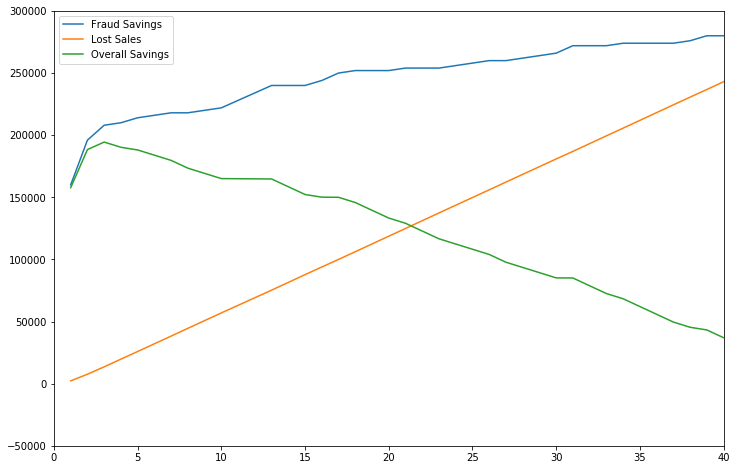

In [113]:
plt.figure(figsize=(12,8))
plt.plot(oott['bins'],oott['fraud_saving'],label='Fraud Savings')
plt.plot(oott['bins'],oott['lost_sales'], label='Lost Sales')
plt.plot(oott['bins'],oott['overall_saving'], label='Overall Savings')
plt.xlim(0,40)
plt.ylim(-50000,300000)
plt.legend()
plt.show()

In [115]:
oott['overall_saving'].max()

194450.0

In [119]:
np.quantile(y_oot_pred_prob,0.97)

0.09169646107770217

In [122]:
oot_df.loc[int(len(oot_df)*0.03),:]

index        3673.000000
pred_prob       0.091939
label           0.000000
bins            3.000000
Name: 372, dtype: float64